[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/Burgers_1D_main.ipynb)

In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [2]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [3]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [4]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        # comp. domain
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = -torch.sin(math.pi * ic[:,0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred,self.y_train)

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx , (0.01/math.pi) * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [5]:
# training
net = Net()
net.train()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.16560488939285278
200 0.08920406550168991
300 0.07644448429346085
400 0.06346341967582703
500 0.04021729528903961
600 0.027670443058013916
700 0.02162111923098564
800 0.01831703446805477
900 0.014593595638871193
1000 0.01285385712981224
1100 0.00823361985385418
1200 0.00458159577101469
1300 0.002999400720000267
1400 0.0023715579882264137
1500 0.0014695946592837572
1600 0.0010825823992490768
1700 0.0007832810515537858
1800 0.0006072206306271255
1900 0.00043903966434299946
2000 0.00033022757270373404
2100 0.000227164346142672
2200 0.00017733839922584593
2300 0.00015057966811582446
2400 0.00013929835404269397
2500 0.00012739589146804065
2600 0.00012127694208174944
2700 0.0001139000232797116
2800 0.00010565371485427022
2900 0.00010054003359982744
3000 9.487759962212294e-05
3100 8.97253630682826e-05
3200 8.359126513823867e-05
3300 7.851819100324064e-05
3400 7.301043660845608e-05
3500 6.784306606277823e-05
3600 6.351490446832031e-05
3700 5.9876452723983675e-05
3800 5.762534783571027e-0

In [6]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [7]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [8]:
X

tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0100],
        [-1.0000,  0.0200],
        ...,
        [ 0.9900,  0.9700],
        [ 0.9900,  0.9800],
        [ 0.9900,  0.9900]])

In [9]:
X.shape

torch.Size([20000, 2])

In [10]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [11]:
y_pred.shape

(200, 100)

In [12]:
y_pred

array([[ 0.00283241,  0.00234878,  0.00197548, ..., -0.00163502,
        -0.00160974, -0.00157917],
       [ 0.03473318,  0.03328693,  0.03200012, ...,  0.00601554,
         0.00598133,  0.00595313],
       [ 0.06639111,  0.06400216,  0.06181836, ...,  0.01367915,
         0.0135842 ,  0.01349711],
       ...,
       [-0.09533331, -0.09260377, -0.09005636, ..., -0.02476022,
        -0.02457047, -0.02438563],
       [-0.06318989, -0.06142837, -0.05979711, ..., -0.01666552,
        -0.01653495, -0.01640815],
       [-0.03072304, -0.02995303, -0.02925971, ..., -0.0085479 ,
        -0.00847682, -0.0084087 ]], dtype=float32)

In [13]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred, cmap='jet')

<Axes: >

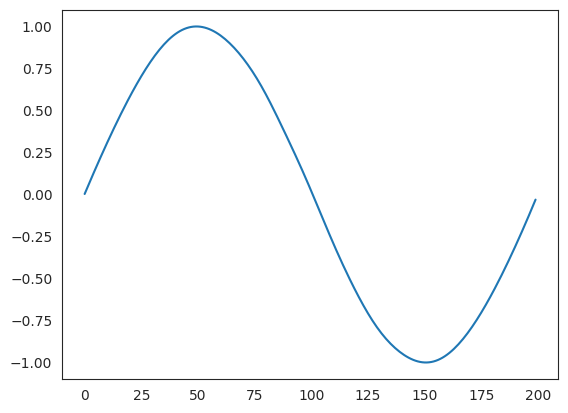

In [14]:
plt.plot(y_pred[:,0])

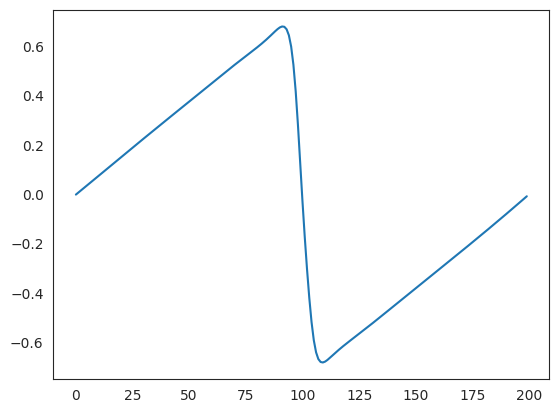

In [15]:
plt.plot(y_pred[:,-1])

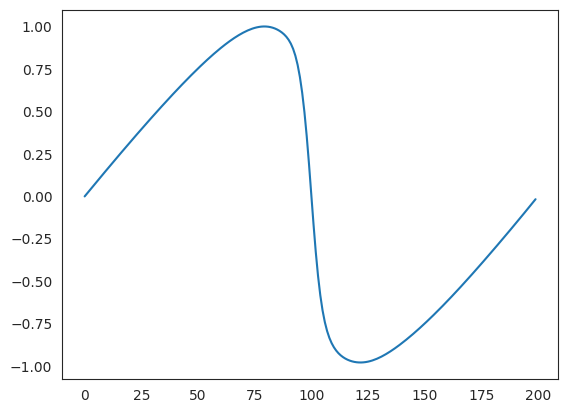

In [16]:
plt.plot(y_pred[:,30])